### Урок 6. Кейс 2. Данные в страховом бизнесе. EDA


In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

__1. повторить анализ набора данных WA_Fn-UseC_-Telco-Customer-Churn.csv (желательно придумать какие-то дополнительные признаки)__


In [2]:
telcom = pd.read_csv("../lesson6/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

In [4]:
def CreateFeature(df, columns, grouped_feature,featurename):
    return df.groupby(columns)[[grouped_feature]]\
                    .median().reset_index()\
                    .rename(columns={grouped_feature:featurename})

def MergeFeature(df, columns, featurename, feature):
    df = pd.merge(df, feature, on=columns, how='left')
    df.loc[df[featurename].isnull(), featurename]\
        = df[featurename].median()    
    return df

def ExpandDataOnFeature(df, columns, grouped_feature, featurename ):
    feature = CreateFeature(df,columns, grouped_feature, featurename)
    df =  MergeFeature(df, columns, featurename, feature)
    return df

In [5]:
#Добавление новых признаков
telcom = ExpandDataOnFeature(telcom,'tenure','TotalCharges', 'TotalCharges_tenure')
telcom = ExpandDataOnFeature(telcom,'tenure','MonthlyCharges', 'MonthlyCharges_tenure')
telcom['avg_month_charges'] = telcom['TotalCharges'] / telcom['MonthlyCharges']


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

In [7]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

In [8]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.53      0.60       490

    accuracy                           0.80      1758
   macro avg       0.76      0.72      0.74      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8031854379977247
Area under curve :  0.7201908839245477 



D:\Compile\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



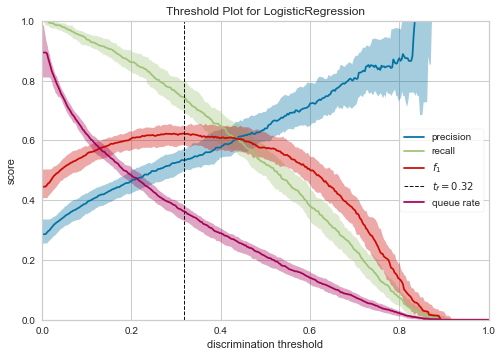

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]


def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

__2. дополнить список моделей еще как минимум тремя (lightgbm, xgboost, svm, knn, naivebayes, сети, что-то еще)__


In [10]:
result_table = pd.DataFrame(columns=['alg', 'precision_0', 'recall_0', 'f1-score_0',
                                     'precision_1', 'recall_1', 'f1-score_1'])

In [11]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import ast 

In [13]:
cols    = [i for i in telcom.columns if i not in Id_col+target_col]

X = telcom[cols]
y = telcom[target_col]

#Split train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = .25 , random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(X_train,y_train)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###





In [14]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(os_smote_X, os_smote_Y)

y_test_pred = model_xgb.predict(X_test)

res = classification_report(y_test, y_test_pred, output_dict=True)
result_table.loc[0] = ['XGBClassifier', res['0']['precision'], res['0']['recall'], res['0']['f1-score']
                                      , res['1']['precision'], res['1']['recall'], res['1']['f1-score']]




In [15]:
model_knn = KNeighborsClassifier()
model_knn.fit(os_smote_X, os_smote_Y)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

res = classification_report(y_test, y_test_pred, output_dict=True)
result_table.loc[1] = ['KNeighborsClassifier', res['0']['precision'], res['0']['recall'], res['0']['f1-score']
                                      , res['1']['precision'], res['1']['recall'], res['1']['f1-score']]



In [16]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(os_smote_X, os_smote_Y)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

res = classification_report(y_test, y_test_pred, output_dict=True)
result_table.loc[2] = ['CatBoostClassifier', res['0']['precision'], res['0']['recall'], res['0']['f1-score']
                                      , res['1']['precision'], res['1']['recall'], res['1']['f1-score']]



In [17]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators':[50, 100, 200, 500, 700],
          'max_depth':[1,2,3,4,5]}
cv=KFold(n_splits=4, random_state=21, shuffle=True)


forest = RandomForestClassifier(max_depth=7, n_estimators = 100, random_state=42, class_weight={0:0.5, 1:1.5})
rs = RandomizedSearchCV(forest, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(os_smote_X, os_smote_Y)
param = rs.best_params_

clf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators = param['n_estimators'], random_state=17, class_weight={0:0.5, 1:1})
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

res = classification_report(y_test, y_test_pred, output_dict=True)
result_table.loc[3] = ['RandomForestClassifier', res['0']['precision'], res['0']['recall'], res['0']['f1-score']
                                               , res['1']['precision'], res['1']['recall'], res['1']['f1-score']]


__3. на выходе сформировать единую таблицу метрик качества со всеми моделями__


In [18]:
result_table = result_table.set_index('alg')

In [19]:
result_table

,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
alg,,,,,,
XGBClassifier,0.849206,0.843849,0.846519,0.602410,0.612245,0.607287
KNeighborsClassifier,0.869442,0.724763,0.790538,0.502140,0.718367,0.591100
CatBoostClassifier,0.852682,0.839905,0.846246,0.601179,0.624490,0.612613
RandomForestClassifier,0.889083,0.802839,0.843763,0.592170,0.740816,0.658205


__4. сделать выводы о том, какие модели лучше справляются с задачей прогноза оттока на этой выборке__


Явного лидера не видно. Каждый алгоритм в чем-то выигрывает, а в чем-то проигрывает.

__5. есть ли смысл в этапе отборе признаков с точки зрения повышения качества прогнозов__


Да, т.к. может найтись такой признак, который отрицательно влияет на прогноз. Например, кто-то пошутил и добавил random(0,1)  

6. (опционально) сделать подбор параметров (без особого усердия) для лучшей (можно нескольких) моделей и проверить качество снова